Make essential imports

In [50]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

Import Amazon's closing stock values

In [34]:
df = pd.read_csv('Amazon.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


Normalizing the data

In [35]:
X = df.Close.values
mean = np.mean(X)
std = np.std(X)
X_norm = (X-mean)/std
X_norm

array([-0.60526753, -0.60553506, -0.60555938, ...,  3.26867136,
        3.3336959 ,  3.357184  ])

Divide my data into a sliding window of 5 days

In [36]:
X_data = np.zeros((len(X_norm)-6, 5))
Y_data = np.zeros((len(X_norm)-6))
for i in range(len(X_norm)-6):
  X_data[i,0:5] = X_norm[i:i+5]
  Y_data[i] = X_norm[i+6]


Reshape the data to be used in LSTMs

In [37]:
X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], 1)
X_data

array([[[-0.60526753],
        [-0.60553506],
        [-0.60555938],
        [-0.6056445 ],
        [-0.60588772]],

       [[-0.60553506],
        [-0.60555938],
        [-0.6056445 ],
        [-0.60588772],
        [-0.6059242 ]],

       [[-0.60555938],
        [-0.6056445 ],
        [-0.60588772],
        [-0.6059242 ],
        [-0.60580259]],

       ...,

       [[ 3.37216193],
        [ 3.4161965 ],
        [ 3.41317281],
        [ 3.37921311],
        [ 3.40250284]],

       [[ 3.4161965 ],
        [ 3.41317281],
        [ 3.37921311],
        [ 3.40250284],
        [ 3.28639253]],

       [[ 3.41317281],
        [ 3.37921311],
        [ 3.40250284],
        [ 3.28639253],
        [ 3.26867136]]])

Split into train/test sets

In [40]:
X_train = X_data[0:5600]
y_train = Y_data[0:5600]
X_test = X_data[5600:-1]
y_test = Y_data[5600:-1]

Create LSTM model with: Adam optimizer, MSE loss and a monitor on the validation MSE

In [41]:
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_data.shape[1], X_data.shape[2]), kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.1)),
    Dense(1, activation='linear')
])
model.compile(metrics=['mse'], optimizer='Adam', loss='mse')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/best_weights.h5",
    monitor='val_mse',
    mode='min',
    save_best_only=True)

In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=None, epochs=100, callbacks=model_checkpoint_callback)

Epoch 1/100
175/175 [==============================] - 3s 8ms/step - loss: 0.1874 - mse: 0.0316 - val_loss: 0.1182 - val_mse: 0.0942
Epoch 2/100
175/175 [==============================] - 1s 5ms/step - loss: 0.0123 - mse: 9.8447e-04 - val_loss: 0.1777 - val_mse: 0.1726
Epoch 3/100
175/175 [==============================] - 1s 5ms/step - loss: 0.0050 - mse: 0.0012 - val_loss: 0.1118 - val_mse: 0.1089
Epoch 4/100
175/175 [==============================] - 1s 5ms/step - loss: 0.0038 - mse: 0.0013 - val_loss: 0.0853 - val_mse: 0.0831
Epoch 5/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0034 - mse: 0.0013 - val_loss: 0.0832 - val_mse: 0.0813
Epoch 6/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0035 - mse: 0.0016 - val_loss: 0.0855 - val_mse: 0.0837
Epoch 7/100
175/175 [==============================] - 1s 4ms/step - loss: 0.0032 - mse: 0.0014 - val_loss: 0.1101 - val_mse: 0.1082
Epoch 8/100
175/175 [==============================] - 1s 4ms/ste

In [45]:
model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 0.0666 - mse: 0.0659


[0.06663453578948975, 0.06590475887060165]

Getting Y_pred to plot it on the graph

In [47]:
Y_pred = (model(X_data)*std)+mean
Y_data = (Y_data*std)+mean
Y_pred = tf.reshape(Y_pred, shape=(Y_pred.shape[0]))

Compare the values of Y_true (Y_data) and Y_pred to visually evaluate algorithm's performance

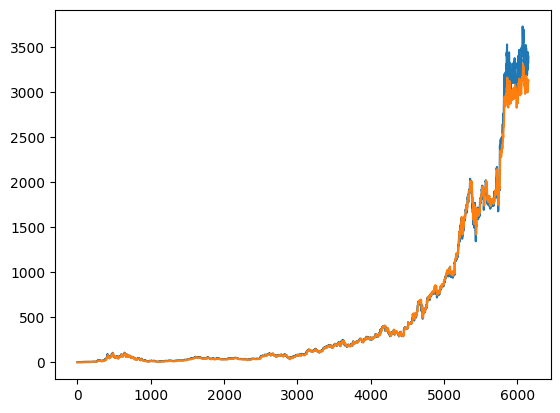

In [49]:
fig, ax = plt.subplots()
x_axis = np.linspace(1,  Y_pred.shape[0], Y_pred.shape[0])
ax.plot(x_axis, Y_data)
ax.plot(x_axis, Y_pred)
plt.show()